#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импортируем и изучаем данные

In [1]:
# Необходимые импорты

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
import catboost as cat
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [2]:
# Сохраняем информацию файла в датафрейме data
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
# data.sort_index(inplace=True) Изначально хотел отсортировать индексы, но в датафрейме они итак идут в нужном порядке
# data.index.is_monotonic

data.head() # Выводим первые строчки датафрейма для ознакомления

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info() # Смотрим общую информацию

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.describe() # Смотрим распределения значений

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
data[data['num_orders'] == 0].count() # Считаем строки, у которых количество заказов равно нулю

num_orders    537
dtype: int64

In [6]:
data.index.max() - data.index.min()

Timedelta('183 days 23:50:00')

По полученным данным можно сделать следующие выводы:
* Мы имеем датафрейм с одном столбцом - количество заказов такси. И индексом в виде времени;
* Пропущенных значений у нас нет;
* В данных есть 537 строк с нулевым количеством заказов;
* Типы данных имеют корректный вид;
* Данные у нас почти за 184 дня.

## Анализ

In [7]:
data = data.resample('1H').sum() # Выполняем ресемплемирование по часам

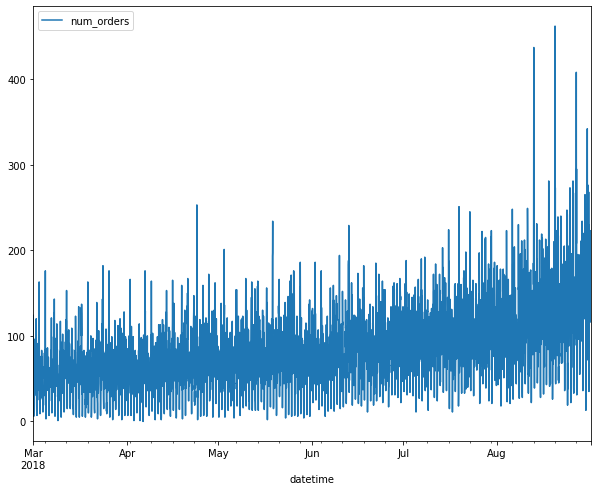

In [8]:
data.plot(figsize=(10,8)) # Выводим на экран график по заказам такси
None

По такому графику едва ли можно сделать какие-либо выводы.

In [9]:
# Раскладываем временной ряд на три составляющие: тренд, сезонность и остаток
decomposed = seasonal_decompose(data)

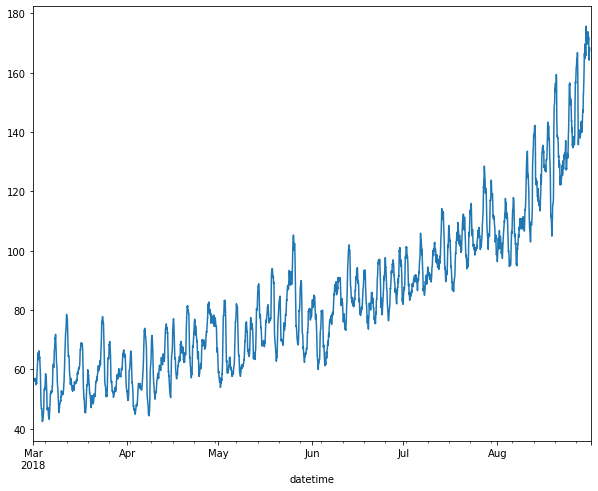

In [10]:
decomposed.trend.plot(figsize=(10,8))
None

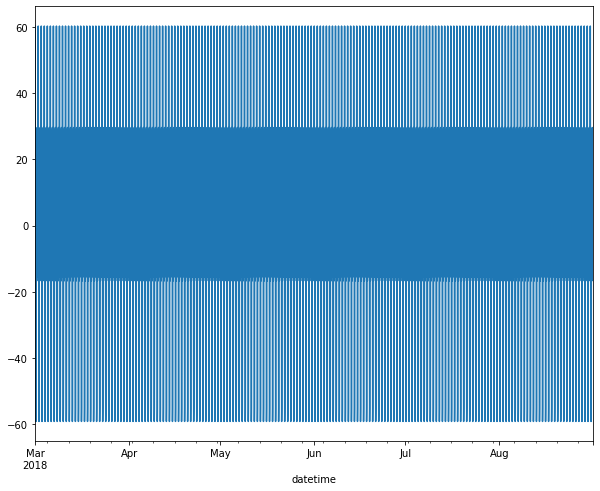

In [11]:
decomposed.seasonal.plot(figsize=(10,8))
None

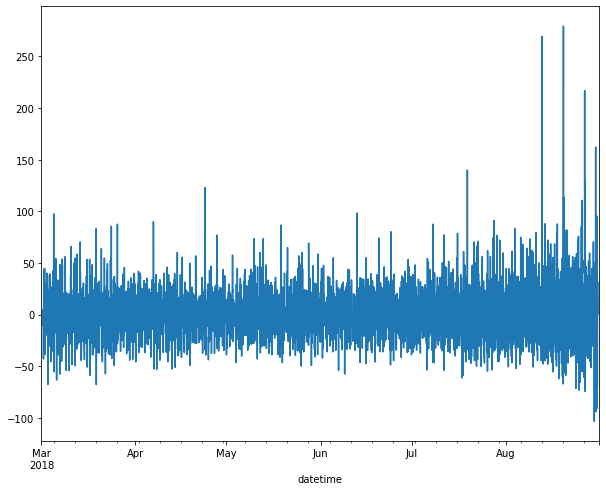

In [12]:
decomposed.resid.plot(figsize=(10,8))
None

2018-08-31 23:00:00


<AxesSubplot:xlabel='datetime'>

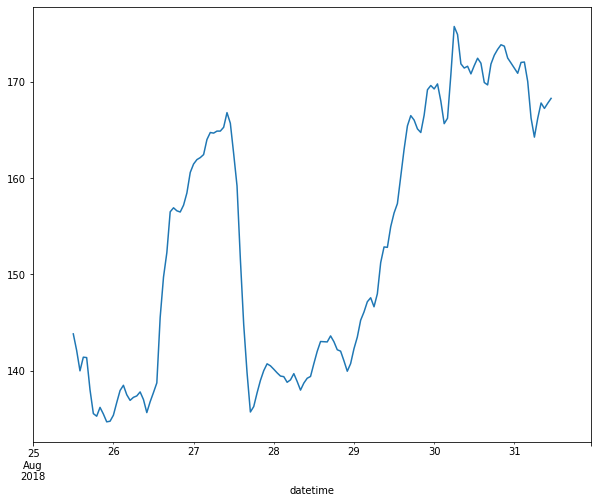

<AxesSubplot:xlabel='datetime'>

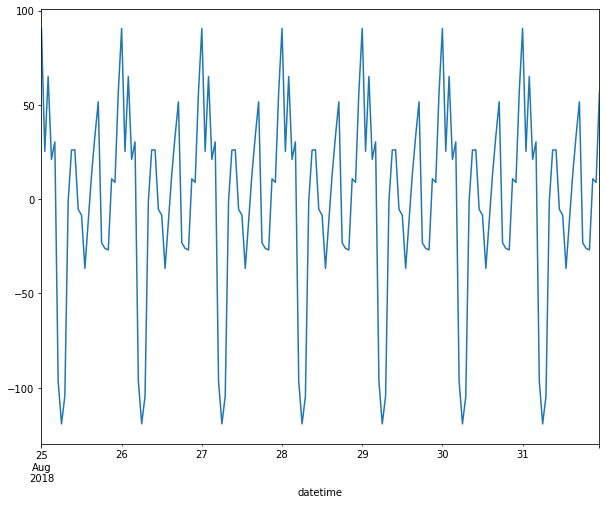

<AxesSubplot:xlabel='datetime'>

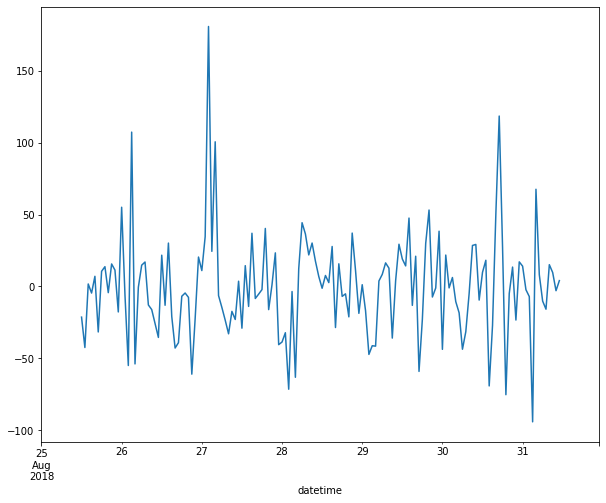

In [13]:
print(data.index.max()) # Смотрим, какой датой ограничивается наш набор данных
# Возьмем для построения графиков последнюю неделю
decomposed = seasonal_decompose(data['2018-08-25':'2018-08-31'])

# Смотрим на графики еще раз
display(decomposed.trend.plot(figsize=(10,8)))
plt.show()
display(decomposed.seasonal.plot(figsize=(10,8)))
plt.show()
display(decomposed.resid.plot(figsize=(10,8)))

* Теперь хорошо прослеживается сезонность.
* Можно смело заявить, что ночью заказы стремятся к нулю, а вечером происходит пик спроса.
* В целом, количество заказов растет

<AxesSubplot:xlabel='datetime'>

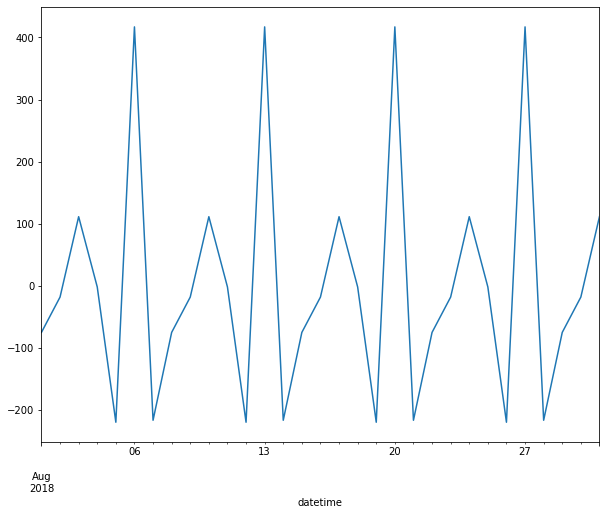

In [14]:
data_day = data.resample('1D').sum()
decomposed_day = seasonal_decompose(data_day['2018-08-01':'2018-08-31'])
display(decomposed_day.seasonal.plot(figsize=(10,8)))

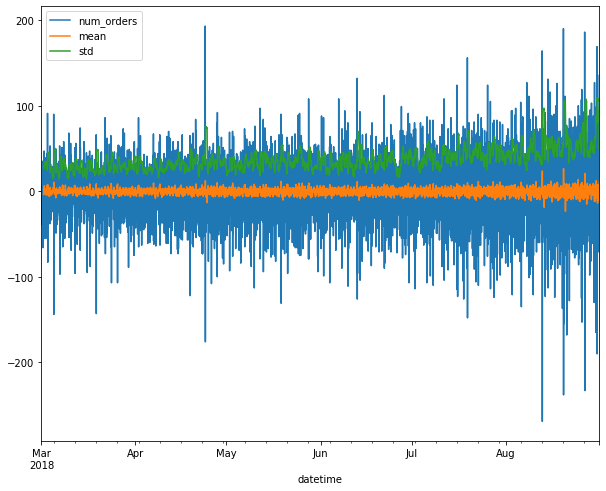

In [15]:
new_data = data - data.shift()
new_data['mean'] = new_data['num_orders'].shift().rolling(15).mean() # скользящее среднее с окном размером 15
new_data['std'] = new_data['num_orders'].shift().rolling(15).std() # стандартное отклонение
new_data.plot(figsize=(10,8))
None

## Обучение

### Деление на выборки

In [16]:
max_lag = 24 # задаем максимальный размер отставания
rolling_mean_size = 48 # задаем ширину окна
def make_features(data, max_lag, rolling_mean_size): # создаем признаки
#     data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
#     data['month'] = data.index.month
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
make_features(data, max_lag, rolling_mean_size) # запускаем функцию

# производим деление на выборки
# тестовая у нас должна быть 10%
train, test = train_test_split(data, shuffle=False, test_size=0.2, random_state=12345)
valid, test = train_test_split(test, shuffle = False, test_size = 0.5, random_state=12345)
train = train.dropna()

# features_train = train.drop('num_orders', axis=1)
# target_train = train['num_orders']
# features_test = test.drop('num_orders', axis=1)
# target_test = test['num_orders']

# print(features_train.shape) # проверяем
# print(features_test.shape)
# print(target_train.shape)
# print(target_test.shape)

(features_train,
features_valid,
features_test) = (train.drop('num_orders',axis = 1),
                  valid.drop('num_orders',axis = 1),
                  test.drop('num_orders',axis = 1))
(target_train,
target_valid,
target_test) = (train['num_orders'],
                valid['num_orders'],
                test['num_orders'])

### Линейная регрессия

In [83]:
%%time

model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
pred_LR = model_LR.predict(features_valid)
mean_squared_error(target_valid, pred_LR)**0.5

CPU times: user 50.4 ms, sys: 35.6 ms, total: 85.9 ms
Wall time: 15.8 ms


34.26160725839712

### CatBoost

In [19]:
%%time

data_train = cat.Pool(features_train, target_train)
# data_train = cat.Pool(features_test, target_test)
model_cat = CatBoostRegressor(random_state = 12345)
param = {'depth' : [3, 6, 10],
                'learning_rate' : [0.03, 0.1],
                'iterations' : [1000, 2000],
                'verbose' : [False]
               }
tscv = TimeSeriesSplit(n_splits=8)
gsearch_cat = GridSearchCV(estimator=model_cat, cv=tscv,
                        param_grid=param, scoring = 'neg_root_mean_squared_error')
gsearch_cat.fit(features_train, target_train)

CPU times: user 33min 20s, sys: 16.1 s, total: 33min 36s
Wall time: 35min 20s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f0ee9e8f2e0>,
             param_grid={'depth': [3, 6, 10], 'iterations': [1000, 2000],
                         'learning_rate': [0.03, 0.1], 'verbose': [False]},
             scoring='neg_root_mean_squared_error')

In [20]:
display('RMSE:', np.abs(gsearch_cat.best_score_))
display('Лучшие параметры:', gsearch_cat.best_params_)

'RMSE:'

22.258904091600584

'Лучшие параметры:'

{'depth': 6, 'iterations': 2000, 'learning_rate': 0.03, 'verbose': False}

### LGBM

In [21]:
%%time

model_LGBM = LGBMRegressor(random_state = 12345)
param = {'depth' : [-1, 3, 6, 10],
                'learning_rate' : [0.03, 0.1],
                'n_estimators' : [100, 200, 1000]
               }
tscv = TimeSeriesSplit(n_splits=5)
gsearch_LGBM = GridSearchCV(estimator=model_LGBM, cv=tscv,
                        param_grid=param,scoring = 'neg_root_mean_squared_error')
gsearch_LGBM.fit(features_train, target_train)

[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown param

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'depth': [-1, 3, 6, 10], 'learning_rate': [0.03, 0.1],
                         'n_estimators': [100, 200, 1000]},
             scoring='neg_root_mean_squared_error')

In [22]:
display('RMSE:', np.abs(gsearch_LGBM.best_score_))
display('Лучшие параметры:', gsearch_LGBM.best_params_)

'RMSE:'

23.99822262172281

'Лучшие параметры:'

{'depth': -1, 'learning_rate': 0.03, 'n_estimators': 200}

## Тестирование

In [82]:
%%time

model_cat = CatBoostRegressor(depth = 3, iterations = 2000, learning_rate = 0.1, loss_function = 'RMSE')
model_cat.fit(data_train, eval_set = data_train, verbose = False);

display(mean_squared_error(target_test, model_cat.predict(features_test))**0.5)

48.963078870617046

CPU times: user 2.98 s, sys: 273 ms, total: 3.25 s
Wall time: 4.39 s


In [84]:
%%time

model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
pred_LR = model_LR.predict(features_test)
mean_squared_error(target_test, pred_LR)**0.5

CPU times: user 10.9 ms, sys: 43.1 ms, total: 54 ms
Wall time: 10.5 ms


45.495426280377195

In [87]:
# model_LGBM = LGBMRegressor(depth = -1,n_estimators = 200, learning_rate = 0.03, random_state = 12345)
# model_LGBM.fit(features_train, target_train, eval_set = (features_test, target_test), eval_metric = 'RMSE', verbose = 10);

In [88]:
# mean_squared_error(target_test, model_LGBM.predict(features_test))**0.5

## Общий вывод

В данном проекте перед нами стояла цель спрогнозировать количество заказов такси на следующий час. Для ее достижения мы обучили три разные модели, которые добились необходимого результата RMSE < 48.
По итогам обучения получили следующие показатели:
* CatBoost - `22.25`;
* Линейная регрессия - `34.26`;
* LGBM - `23.99`.

На их основе отдали свое предпочтение модели CatBoost, т.к. значение именно у нее было минимальным, и провели ее проверку на тестовом наборе данных.